In this notebook we will investigate Logistic Regression -- a binary classification task. Our goal is to solve a specific instantiation of this machine learning problem using a Gradient Descent algorithm implemented here. Before we begin, we will import neccessary packages and note some prelimary math.

In [39]:
import numpy as np
import numpy.linalg as lg
import pandas as pd
import scipy.special as sps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
rng = np.random.default_rng()

We have a data matrix $\mathbf{X}\in\mathbb{R}^{n x p}$ whose ith row is a set of features relating to some observation, and we are looking for the weights $\mathbf{w}\in\mathbb{R}^p$. Each observation $\mathbf{x}_i$ has a binary response $y_i$ which is either -1 or 1.

Our loss function is the negative log-likelihood defined below:

$$ \ell(\mathbf{w})=\sum_{i=1}^n\log(1+e^{-y_i\mathbf{w}^T\mathbf{x}_i}) $$

The gradient of this is given as follows:

$$ \nabla\ell(\mathbf{w})=-\sum_{i=1}^n\sigma(-y_i\mathbf{w}^T\mathbf{x}_i)y_i\mathbf{x}_i $$

In the code below we define the negative log-likelihood, its gradient, and its hessian (which was not shown above). We note that the code may look somewhat different as it has been condensed into matrix-vector form, but the result is the same.

In [40]:
'''
w -> px1 column vector
X -> nxp matrix
y -> nx1 column vector
'''

#negative log-likelihood
#returns scalar
def nLogLike(w, X, y):
    l = np.logaddexp(np.zeros(y.shape), -y*X@w)
    return np.sum(l)

#negative log-likelihood gradient
#returns vector
def nLogLike_grad(w, X, y):
    u = sps.expit(-y*(X@w))
    
    return -X.T@(y*u)

#negative log-likelihood hessian
#returns matrix
def nLogLike_hess(w, X, y):
    u = sps.expit(-y*(X@w))
    S = np.diag(u*(1-u))
    
    return X.T@S@X

## Problem 1

As we will be using Gradient Descent we will be working with the gradient of our loss function. Below we define a class which implements two methods to validate the gradient of a given function. Specifically, we implement a Dolfin Adjoint check and a Complex Step check which are both fast and numerically stable.

In [42]:
'''
Class with methods to validate the gradient of a given function.

Initialization:
    f -> function
    grad -> function gradient
'''
class GradChecker():
    def __init__(self, f, grad):
        self.f = f
        self.grad = grad
        
        self.dispatcher = {
            'dolfin': self.dolfinAdj,
            'complex': self.complexStep,
        }
        
    def reset(self, f, grad):
        self.f = f
        self.grad = grad
        
    def check(self, method='dolfin', x0=None, dim=None, kwargs={}):
        checker = self.dispatcher[method]
        self.kw = kwargs
        
        rng = np.random.default_rng()
        
        if dim is not None:
            x0 = rng.integers(0,100,(dim,1)) #Random vector
            
        checker(x0)
    
    #NOTE: assumes hessian is smooth
    def dolfinAdj(self, x0):
        valid = True
        
        rng = np.random.default_rng()
        
        x1 = x0*rng.random(x0.shape) #random vector
        f = self.f(x0, **self.kw)
        
        h = np.geomspace(1e-7, 1.0, 8)
        
        for i in range(7,0,-1):
            f0 = self.f(x0 + h[i]*x1, **self.kw)
            e0 = np.abs(f + np.vdot(self.grad(x0, **self.kw), h[i]*x1) - f0)
            
            f1 = self.f(x0 + h[i-1]*x1, **self.kw)
            e1 = np.abs(f + np.vdot(self.grad(x0, **self.kw), h[i-1]*x1) - f1)
            
            if e0!=0 and e1!=0:
                order = np.rint(np.log(e1/e0) / np.log(h[i-1]/h[i]))
                if order != 2:
                    print('Order violated: {}'.format(order))
                    print('Error k,k+1: {},{} \n'.format(e0, e1))
                    
                    valid = False
        
        print('Gradient is valid: {} \n'.format(valid))
    
    #NOTE: assuming a few things related to complex numbers 
    #e.g. analyticity of f
    def complexStep(self, x0):
        valid = True
        
        g0 = self.grad(x0, **self.kw)
        
        h = np.geomspace(1e-7, 1.0, 8)
        
        for i in range(7,0,-1):
            e0 = np.abs(np.sum(g0) - np.imag(self.f(x0 + h[i]*1j, **self.kw) / h[i]))
            
            e1 = np.abs(np.sum(g0) - np.imag(self.f(x0 + h[i-1]*1j, **self.kw) / h[i-1]))
            
            
            if e0!=0 and e1!=0:
                order = np.rint(np.log(e1/e0) / np.log(h[i-1]/h[i]))
                if order != 2:
                    print('Order violated: {}'.format(order))
                    print('Error k,k+1: {}, {} \n'.format(e0, e1))

                    valid = False
                    
        print('Gradient is valid: {} \n'.format(valid))

Before we verify that our gradient implemented above is correct we need to make sure that our method of checking is valid. Who checks that the method to check the method that checks is correct? No one knows.

Note that there is an amount of randomness in the methods implemented above (especially if not specific input is given). Thus we may see in some cases the output changes, but that the true embedded result will stay the same. We can see an example of this in the output immediately below.

In [47]:
#Linear 1D
GC = GradChecker(lambda x: 3*x+2, lambda x: 3)
GC.check(method='dolfin', dim=1)
GC.check(method='complex', dim=1)

Order violated: [[-0.]]
Error k,k+1: [[2.84217094e-14]],[[2.84217094e-14]] 

Order violated: [[-0.]]
Error k,k+1: [[2.84217094e-14]],[[2.84217094e-14]] 

Gradient is valid: False 

Gradient is valid: True 



The above output is the result of checking a simple 1D linear function. We can see that the Dolfin Adjoint output seems to be indicating a problem, but further investigation reveals this isn't the case. Specifically, we see that the error is almost zero (as we expect), so even though it is constant, the gradient is still correct. This is further validated by the output of the Complex Step method.

In [48]:
#Quadratic
GC.reset(lambda x: 2*lg.norm(x)**2+1, lambda x: 4*x)
GC.check(method='dolfin', dim=1)
GC.check(method='dolfin', dim=100)

Gradient is valid: True 

Gradient is valid: True 



The Dolfin Adjoint method verifies the gradient of a quadratic for 1 and 100 dimensional input. We note that the Complex Step method cannot be used in this case.

In [49]:
#Incorrect
GC.reset(lambda x: 2*lg.norm(x)**2+1, lambda x: 4*x+0.1)
GC.check(method='dolfin', dim=1)
GC.check(method='dolfin', dim=100)

Order violated: 1.0
Error k,k+1: 0.016738292912123143,0.0009111543349717977 

Order violated: 1.0
Error k,k+1: 0.0009111543349717977,0.00011696526871673996 

Order violated: 1.0
Error k,k+1: 0.00011696526871673996,1.1955025911447592e-05 

Order violated: 1.0
Error k,k+1: 1.1955025911447592e-05,1.1980873750871979e-06 

Order violated: 1.0
Error k,k+1: 1.1980873750871979e-06,1.1983411241089925e-07 

Gradient is valid: False 

Order violated: 3.0
Error k,k+1: 21.900984321488068,0.02304461132735014 

Order violated: -0.0
Error k,k+1: 0.02304461132735014,0.02443589165341109 

Order violated: 1.0
Error k,k+1: 0.02443589165341109,0.002664903295226395 

Order violated: 1.0
Error k,k+1: 0.002664903295226395,0.0002687035594135523 

Order violated: 1.0
Error k,k+1: 0.0002687035594135523,2.6892521418631077e-05 

Gradient is valid: False 



This time we have purposely entered the incorrect gradient for the quadratic and we see the Dolfin Adjoint method correctly identifies it.

In [52]:
#Cubic
GC.reset(lambda x: (1/3)*x**3+10, lambda x: x**2)
GC.check(method='dolfin', dim=1)
GC.check(method='complex', dim=1)

Gradient is valid: True 

Gradient is valid: True 



Both methods work on a cubic.

In [53]:
#Big and small
z = rng.standard_normal((10,1))

GC.reset(lambda x: 2*lg.norm(x)**2+1, lambda x: 4*x)
GC.check(method='dolfin', dim=10, x0=1e-6*z)
GC.check(method='dolfin', dim=10, x0=1e6*z)

Gradient is valid: True 

Gradient is valid: True 



Lastly, we validate the Dolfin Adjoint method on large and small inputs and it works well.

It seems like our methods are working as expected, so lets see if the gradient for our negative log-likelihood is correct.

In [54]:
p = rng.integers(2,100)
n = rng.integers(p,100)

GC = GradChecker(nLogLike, nLogLike_grad)

kw = {'X' : np.ones((n,p)), 'y' : np.ones((p,1))}

In [58]:
GC.check(method='dolfin', dim=p, kwargs=kw)

Gradient is valid: True 



Whew! That was a lot, but we are now prepared to move on.

## Problem 2

Here we will define a linesearch procedure which is useful in Gradient Descent for determining the step size in a proposed search direction.

In [59]:
'''
Linesearch procedure for determining step size in search direction.

Input:
    x -> current location
    p -> search direction
    t -> initial stepsize
    f -> function
    grad -> gradient
Output:
    stepsize in search direction p
'''
def linesearch(x, p, t, f, grad, kw, c=1e-4, r=0.9):
    
    fk = f(x, **kw)
    gk = grad(x, **kw)
    
    while f(x+t*p, **kw) > \
            fk + c*t*(gk.T@p):
        
        t = r*t
        
    return t

## Problem 3

We will implement a custom Gradient Descent solver which minimizes a function by using its gradient. We include both fixed stepsize and linesearch as options.

In [139]:
from numpy.linalg import norm
import warnings
'''
Gradient Descent solver

Input:
    x0 -> starting location
    f -> function
    grad -> function gradient
    stepsize -> fixed or linesearch
    rtol -> relative tolerance
    maxitr -> maximum iterations
    
Return: minimizer of f
'''
def gradDescent(x0, f, grad, kw, step, steptype='fixed', 
                rtol=1e-5, atol=1e-8, maxItr=1000):
    
    assert steptype in ['fixed', 'linesearch']

    x_vec = [x0]
    
    for i in range(maxItr):
        x1 = x0 - step*grad(x0, **kw)
        
        x_vec.append(x1)
        
        if norm(x1-x0) < atol + rtol*norm(x0):
            return x1, np.array(x_vec)
        
        x0 = x1
        
        if steptype == 'linesearch':
            step = linesearch(x0, -grad(x0,**kw), step*2, f, grad, kw)
    
    warnings.warn('Maximum iterations exceeded without \
                  reaching specified tolerance.', RuntimeWarning)
    
    return x1, np.array(x_vec)

To test the viability of our method we will consider a least squares type problem with $f(x)=\frac{1}{2}||\mathbf{Ax}-\mathbf{b}||^2$. In this case we have a closed form solution that we can compare our numerical method to.

Below we define the function and its gradient.

In [141]:
def f(x, A, b):
    return 0.5*(norm(A@x-b))**2

def gf(x, A, b):
    return A.T@(A@x-b)

Next, we will define a random gaussian matrix and random Gaussian RHS of a random size and compare the results of our two methods. We note that an iid Gaussian matrix is full rank with probability 1.

In [150]:
p = rng.integers(30,100)
n = rng.integers(p,100)

m, s = rng.integers(-4,4), rng.integers(1,3)
A = rng.normal(m, s, (n,p))
b = rng.normal(m, s, (n,1))

x0 = np.ones((p,1))

kw = {'A' : A, 'b' : b}

In [151]:
A.shape

(83, 55)

In [152]:
analytic = np.linalg.solve(A.T@A, A.T@b)

In [153]:
t0 = norm(A, 2)**-2

n_fixed, x_fixed = gradDescent(x0, f, gf, kw, t0)

n_line, x_line = gradDescent(x0, f, gf, kw, t0, 
                               steptype='linesearch')

In [154]:
print('Analytic vs. Fixed: {}'.format(norm(analytic-n_fixed)))
print('Analytic vs. Linesearch: {}'.format(norm(analytic-n_line)))

Analytic vs. Fixed: 0.001566052287834858
Analytic vs. Linesearch: 0.000162560008385913


We see that our Gradient Descent algorithm in both fixed and linesearch modes have converged to result similar to the analytic solution.

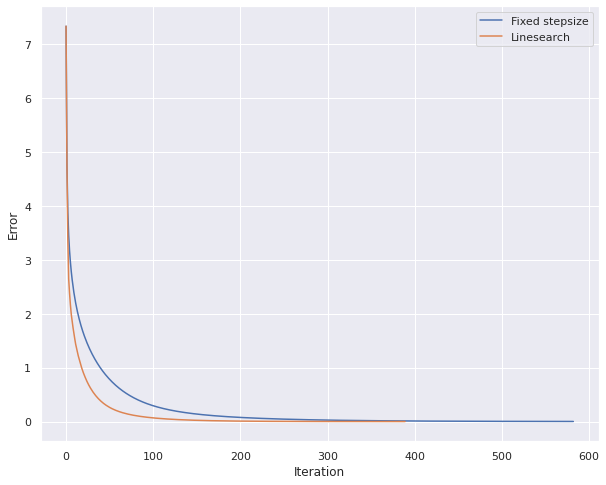

In [155]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(range(0,x_fixed.shape[0]), norm(x_fixed-analytic, axis=1))
ax.plot(range(0,x_line.shape[0]), norm(x_line-analytic, axis=1))

ax.set_xlabel('Iteration')
ax.set_ylabel('Error')
ax.legend(['Fixed stepsize', 'Linesearch']);

In the plot above we can see the error per iteration of our Gradient Descent algorithm. We note that both modes converge, but that linesearch seems to improve the convergence rate -- which is expected.

## Problem 4

Using the tools we have developed up to now we will consider the task of spam email classification. To do this we are using the spambase dataset which we load below and then examine.

In [156]:
data = pd.read_csv('spam_data/spambase.data', sep=",", header=None)
print(data.shape)

(4601, 58)


We see we have 4,601 samples with 58 features each. This is exactly what we expect from the documentation.

In [157]:
print(data.isnull().sum().sum())

0


We have no missing data which is great.

In [158]:
X = data.loc[:,0:56]
y = data.loc[:,57]

In [159]:
print(y.value_counts())

0    2788
1    1813
Name: 57, dtype: int64


We see that we have 2,788 negative examples (not spam), and 1,813 positive samples (spam).

Now we will preprocess our data by transforming the features and mapping the labels from {0,1} to {-1,1}.

In [160]:
X = X.apply(lambda x: np.log(x+0.1))
y = y.replace(0, -1)

In [161]:
print(y.value_counts())

-1    2788
 1    1813
Name: 57, dtype: int64


The output above just serves to validate that our preprocessing worked as we still have the same number of positive and negative examples.

Next we will shuffle our data and extract training and testing splits.

In [162]:
from sklearn.model_selection import train_test_split as split

X_train, X_test, y_train, y_test = split(X, y, test_size=3065, random_state=57, 
                    shuffle=True, stratify=y)

In [163]:
kw_train = {'X' : X_train.to_numpy(), 
            'y' : np.expand_dims(y_train.to_numpy(),1)}

kw_test = {'X' : X_test.to_numpy(), 
           'y' : np.expand_dims(y_test.to_numpy(),1)}

We are ready to train, so we will run the linesearch mode of our Gradient Descent on the training data.

In [164]:
t0 = norm(X_train, 2)**-2
x0 = np.ones((X_train.shape[1],1))

w, w_itr = gradDescent(x0, nLogLike, nLogLike_grad, kw_train, t0, 
                               steptype='linesearch')

<ipython-input-139-3d62410e2001>:36: RuntimeWarning: Maximum iterations exceeded without                   reaching specified tolerance.
  warnings.warn('Maximum iterations exceeded without \


We have set our max number of iterations at 1000, but it is not necessarily bad that we haven't reached our tolerance. Lets see if we can qualify how well our estimator is doing.

In [165]:
def error(X, w, y):
    cls = np.rint(sps.expit(X@w))
    for i in range(cls.shape[0]):
        if cls[i] == 0:
            cls[i] = -1
            
    return np.sum(np.abs(cls-y)/2)/y.shape[0]

In [166]:
print('Train error: {}'.format(error(kw_train['X'], w, kw_train['y'])))
print('Test error: {}'.format(error(kw_test['X'], w, kw_test['y'])))

Train error: 0.046875
Test error: 0.059380097879282216


It looks like we have about 94% accuracy on the testing data which is pretty good.

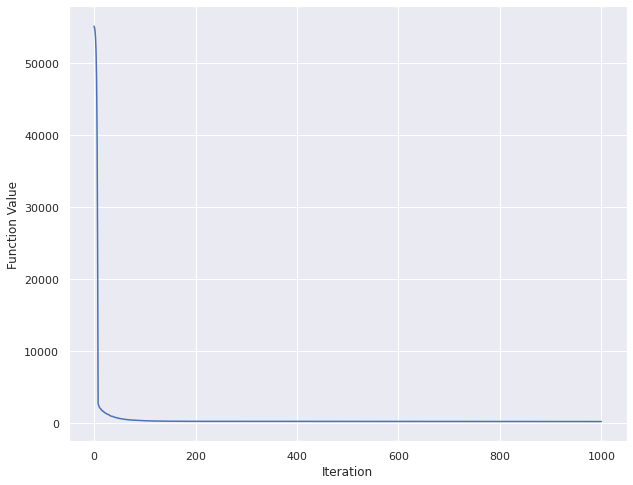

In [170]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
r = range(0,w_itr.shape[0])
ax.plot(r, [nLogLike(w_itr[i], **kw_train) for i in r])

ax.set_xlabel('Iteration')
ax.set_ylabel('Function Value');

We are trying to minimize the negative log-likelihood, and the plot above shows we are doing just that. Given the initially large values it is hard to tell if we are converging at the end or not.

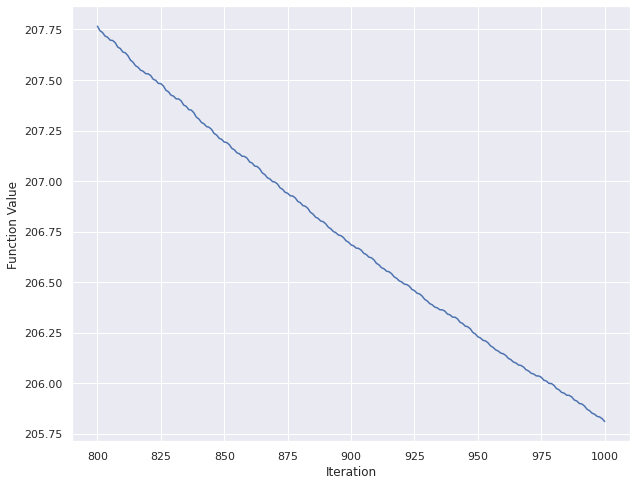

In [171]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
r = range(800,w_itr.shape[0])
ax.plot(r, [nLogLike(w_itr[i], **kw_train) for i in r])

ax.set_xlabel('Iteration')
ax.set_ylabel('Function Value');

It looks like we haven't converged yet, so this implies we could potentially train for further iterations. Although I am not sure if this would cause overfitting.